# QAT 的不同训练策略

载入库：

In [57]:
import torch
from torch import nn, jit
from torch.ao.quantization import quantize_qat
from torchvision.models.quantization import mobilenet_v2

# 载入自定义模块
from mod import torchq
from torchq.xinet import CV
from torchq.helper import evaluate, print_size_of_model, load_model


def create_model(num_classes=10,
                 quantize=False,
                 pretrained=False):
    '''定义模型'''
    float_model = mobilenet_v2(pretrained=pretrained,
                               quantize=quantize)
    # 匹配 ``num_classes``
    float_model.classifier[1] = nn.Linear(float_model.last_channel,
                                          num_classes)
    return float_model


def create_float_model(num_classes,
                       model_path):
    model = create_model(quantize=False,
                         num_classes=num_classes)
    model = load_model(model, model_path)
    return model


In [58]:
torch.cuda.empty_cache() # 清空 GPU 缓存
print(torch.cuda.memory_summary()) # 打印显存

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [59]:
# 设置 warnings
import warnings
warnings.filterwarnings(
    action='ignore',
    category=DeprecationWarning,
    module='.*'
)
warnings.filterwarnings(
    action='ignore',
    module='torch.ao.quantization'
)


def print_info(model, model_type, num_eval, criterion):
    '''打印信息'''
    print_size_of_model(model)
    top1, top5 = evaluate(model, criterion, test_iter)
    print(f'\n{model_type}：\n\t'
          f'在 {num_eval} 张图片上评估 accuracy 为: {top1.avg:2.5f}')

超参数设置：

In [60]:
saved_model_dir = 'models/'
float_model_file = 'mobilenet_pretrained_float.pth'
# scripted_qat_model_file = 'mobilenet_qat_scripted_quantized.pth'
# 超参数
float_model_path = saved_model_dir + float_model_file
batch_size = 16
num_classes = 10
num_epochs = 50
learning_rate = 5e-5
ylim = [0.8, 1]

加载数据集：

In [61]:
# 为了 cifar10 匹配 ImageNet，需要将其 resize 到 224
train_iter, test_iter = CV.load_data_cifar10(batch_size=batch_size,
                                             resize=224)
num_eval = sum(len(ys) for _, ys in test_iter)

Files already downloaded and verified
Files already downloaded and verified


打印浮点模型信息：

In [6]:
float_model = create_float_model(num_classes, float_model_path)
model_type = '浮点模型'
criterion = nn.CrossEntropyLoss(reduction="none")
print_info(float_model, model_type, num_eval, criterion)

模型大小：9.187789 MB

浮点模型：
	在 10000 张图片上评估 accuracy 为: 94.91000


普通策略：

loss 0.013, train acc 0.996, test acc 0.950
352.4 examples/sec on cuda:1


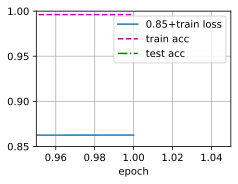

: 

In [62]:
num_epochs = 1
ylim = [0.85, 1]
device = 'cuda:1'
param_group = True

# 量化参数
is_freeze = False
is_quantized_acc = False
need_qconfig = True # 做一些 QAT 的量化配置工作

# 提供位置参数
args = [train_iter,
        test_iter,
        learning_rate,
        num_epochs,
        device,
        is_freeze,
        is_quantized_acc,
        need_qconfig,
        param_group,
        ylim]

qat_model = create_float_model(num_classes, float_model_path)
qat_model.fuse_model(is_qat=True)
quantized_model = quantize_qat(qat_model, CV.train_fine_tuning, args)

In [42]:
for name, param in quantized_model.features.named_parameters():
    print(param.dtype)

torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.

In [56]:
quantized_model

QuantizableMobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): ConvBnReLU2d(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Identity()
      (2): Identity()
    )
    (1): QuantizableInvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): ConvBnReLU2d(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
          (1): Identity()
          (2): Identity()
        )
        (1): ConvBn2d(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
   

In [9]:
qmodel_file = 'mobilenet_quantization_quantized.pth'
torch.save(quantized_model.state_dict(), saved_model_dir + qmodel_file)

冻结前几次训练的量化器以及观测器：

loss 0.004, train acc 0.999, test acc 0.951
237.7 examples/sec on cuda:2


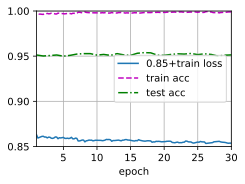

In [9]:
args[5] = True
args[6] = False
qat_model = create_float_model(num_classes, float_model_path)
quantized_model = quantize_qat(qat_model, CV.train_fine_tuning, args)

输出量化精度：

loss 0.004, train acc 0.999, test acc 0.953
239.0 examples/sec on cuda:2


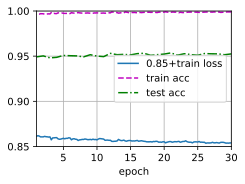

In [10]:
args[6] = True
args[5] = False
qat_model = create_float_model(num_classes, float_model_path)
quantized_model = quantize_qat(qat_model, CV.train_fine_tuning, args)

冻结前几次训练的观测器并且生成量化精度：

loss 0.004, train acc 0.999, test acc 0.951
238.1 examples/sec on cuda:2


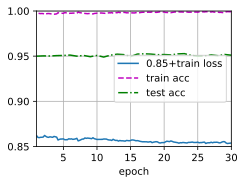

In [11]:
args[5] = True
args[6] = True
qat_model = create_float_model(num_classes, float_model_path)
quantized_model = quantize_qat(qat_model, CV.train_fine_tuning, args)